In [1]:
import io
import pandas as pd
df = pd.read_csv('/Users/inakolluvishnusai/tensorflow/Sarayu/New Data 1.csv') # Dataset is now stored in a Pandas Dataframe

print(df.head())

   Id                                           Judgment  Judgment Status
0   1  appeal judgment decre bombay high court stone ...                1
1   2  applic articl 32 1 constitut enforc applic fun...                2
2   3  appeal judgment high court hyderabad articl 37...                0
3   4  appeal articl 3744 constitut judgment decre hi...                0
4   5  petit art 136 constitut pray special leav appe...                3


In [2]:
sentences = df[['Judgment','Judgment Status']]

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(sentences,  test_size=0.25, random_state=42)

In [3]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(df_train['Judgment Status'])
y_test = to_categorical(df_test['Judgment Status'])

In [4]:
import transformers
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
legalbert_model = TFAutoModelForSequenceClassification.from_pretrained('nlpaueb/legal-bert-base-uncased')

Metal device set to: Apple M1


2023-06-06 22:26:31.913734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-06 22:26:31.913840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=df_train.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=df_test.Judgment.tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [6]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [7]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [8]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = legalbert_model(input_ids, attention_mask = input_mask)[0]
out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [9]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss=loss, 
    metrics = metric)

In [10]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=15,
    batch_size=32
)

Epoch 1/15


2023-06-06 22:26:36.253812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/inakolluvishnusai/tensorflow/env/lib/python3.8/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-06-06 22:26:42.301841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 1.3834 - balanced_accuracy: 0.2924

2023-06-06 22:27:40.276275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 78s 6s/step - loss: 1.3834 - balanced_accuracy: 0.2924 - val_loss: 1.3809 - val_balanced_accuracy: 0.3656
Epoch 2/15
9/9 [==============================] - 35s 4s/step - loss: 1.3741 - balanced_accuracy: 0.3394 - val_loss: 1.3764 - val_balanced_accuracy: 0.3656
Epoch 3/15
9/9 [==============================] - 35s 4s/step - loss: 1.3682 - balanced_accuracy: 0.3394 - val_loss: 1.3766 - val_balanced_accuracy: 0.3656
Epoch 4/15
9/9 [==============================] - 38s 4s/step - loss: 1.3663 - balanced_accuracy: 0.3466 - val_loss: 1.3763 - val_balanced_accuracy: 0.3656
Epoch 5/15
9/9 [==============================] - 40s 5s/step - loss: 1.3580 - balanced_accuracy: 0.3646 - val_loss: 1.3726 - val_balanced_accuracy: 0.3656
Epoch 6/15
9/9 [==============================] - 39s 4s/step - loss: 1.3405 - balanced_accuracy: 0.3394 - val_loss: 1.3730 - val_balanced_accuracy: 0.3548
Epoch 7/15
9/9 [==============================] - 36s 4s/step - loss: 1.309

In [11]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

2023-06-06 22:35:52.710698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 17s 4s/step


array([0.5545927, 0.5295741, 0.4954029, 0.5102699], dtype=float32)

In [12]:
import numpy as np

y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = df_test['Judgment Status']

In [13]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_true, y_predicted))

print(accuracy_score(y_true,y_predicted))

              precision    recall  f1-score   support

           0       0.35      0.73      0.47        30
           1       0.43      0.38      0.41        34
           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00        14

    accuracy                           0.38        93
   macro avg       0.20      0.28      0.22        93
weighted avg       0.27      0.38      0.30        93

0.3763440860215054


/Users/inakolluvishnusai/tensorflow/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/inakolluvishnusai/tensorflow/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/inakolluvishnusai/tensorflow/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [14]:
x_train ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']}

loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.5848


In [15]:
x_test = {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.3763


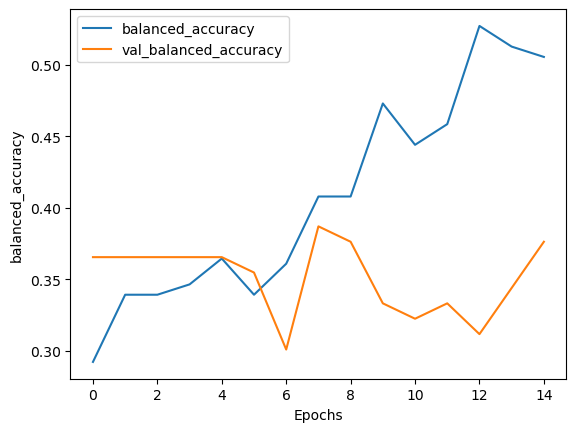

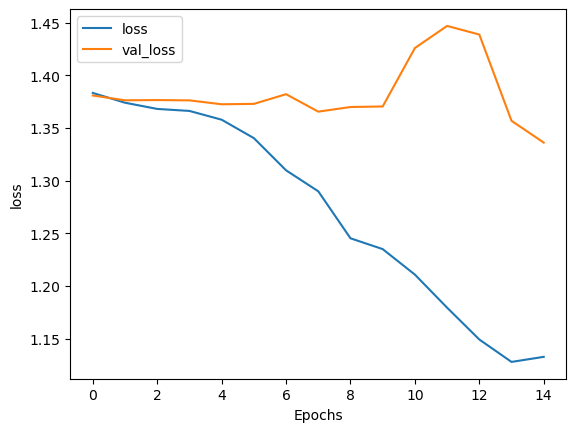

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(train_history, "balanced_accuracy")
plot_graphs(train_history, "loss")

In [18]:
model.save("BERT-LegalBert.h5")